<a href="https://colab.research.google.com/github/gmenendez0/7506R-2C2023-GRUPO07/blob/main/TP2/Modelos/RedesNeuronalesTP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import joblib

#modelos y métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_text

import nltk
from nltk import tokenize
# Descargamos las stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Importamos el interfaz SnowballStemmer que tiene versión en Español para las derivaciones de palabras
from nltk.stem import SnowballStemmer

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MaxAbsScaler
import scipy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
dsTrain = pd.read_csv('train.csv')
dsTest = pd.read_csv('test.csv')
dsTrainCopy = dsTrain.copy()
dsTestCopy = dsTest.copy()

In [4]:
dsTest = pd.read_csv('test.csv')

# Preprocesamiento

Hacemos que el setimiento sea 1 si es positivo y 0 si es negativo para poder correr los modelos, ademas cambiamos el label de 'sentimiento' a 'label'

In [5]:
dsTrainCopy['label'] = (dsTrainCopy['sentimiento']=='positivo').astype(int)
dsTrainCopy.drop('sentimiento', axis=1, inplace=True)
dsTrainCopy.head()


,ID,review_es,label
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


Mostramos los stopwords que hay en ingles

In [6]:
stop_words_sp = set(stopwords.words('english'))
print(stop_words_sp)

{'then', 'has', 'during', "she's", 'yourself', 'whom', "haven't", 'you', 'about', "needn't", 'did', 'having', 'isn', 'o', 'myself', 'does', 'as', 'y', 'her', "mustn't", 'a', "didn't", 'these', 'own', 'now', 'we', 'any', 've', 'such', 'hasn', 'can', 'if', 'yourselves', "it's", 'had', "won't", 'll', 'aren', 'hers', 'our', 'both', 'who', 'of', 'against', 'he', 'herself', 'this', 'from', 'when', "hadn't", 'by', 'but', "you'd", 'on', "weren't", 's', "isn't", 'have', 'doesn', 'didn', 'hadn', 'because', 'why', 'd', 'up', 'don', 'me', 'or', 'being', 'are', "wasn't", 'after', 'yours', 'them', 'what', 'where', 'only', 'above', 'while', 'should', 'all', 'am', 'wouldn', 'that', 'before', 'below', 'those', "mightn't", 'themselves', "couldn't", 'off', 'their', "that'll", 'won', 'than', 'again', 'she', 'once', 'until', 'down', 'itself', 'its', 'each', 'his', 'nor', "aren't", 'other', 'there', 'was', 'not', 'haven', 'most', 'wasn', 'do', 'to', 'just', 'it', 'the', "don't", 'how', 're', 'for', 'into', 

Mostramos los stopwords que hay en español

In [7]:
stop_words_sp = set(stopwords.words('spanish'))
print(stop_words_sp)

{'ellas', 'está', 'tendrá', 'contra', 'hay', 'sobre', 'sentidos', 'tuviera', 'tuviéramos', 'eras', 'otra', 'tendremos', 'ese', 'habremos', 'tuvieran', 'eran', 'tuvieseis', 'mío', 'este', 'estuve', 'seré', 'hubierais', 'tenían', 'uno', 'de', 'estos', 'estar', 'nada', 'hayas', 'tenga', 'seríais', 'todos', 'estaba', 'su', 'serás', 'ti', 'hubieseis', 'fuera', 'estarían', 'fuerais', 'serían', 'mucho', 'tuviese', 'una', 'esas', 'están', 'estas', 'estéis', 'mí', 'estado', 'tus', 'eso', 'habiendo', 'estaremos', 'tendré', 'hayáis', 'hubiéramos', 'seréis', 'seamos', 'donde', 'hube', 'se', 'porque', 'teniendo', 'nosotras', 'habida', 'más', 'estando', 'tendríais', 'habían', 'estuviésemos', 'es', 'tuvieses', 'tuvimos', 'tengan', 'vuestro', 'con', 'hubiste', 'fuésemos', 'sí', 'tuvo', 'estará', 'estamos', 'muchos', 'míos', 'estaban', 'has', 'nuestra', 'suyo', 'será', 'sus', 'tenidas', 'sentida', 'o', 'estás', 'sintiendo', 'tienen', 'esta', 'otros', 'antes', 'era', 'cual', 'a', 'estuvieran', 'estaré',

Hay varias palabras en español que tienen acentos, por ende se los vamos a sacar

In [8]:
import re
def quitar_acentos(texto):
    reemplazar = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in reemplazar:
        texto = texto.replace(a, b).replace(a.upper(), b.upper())
    return texto

stemmer = SnowballStemmer("spanish")
def tokenize(text):
    text = re.sub('[^a-z0-9ñ ]', '', text)
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

# Vectorizacion

In [9]:
vecTrain = TfidfVectorizer()
vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out().size

175853

Dado que hay mucha cantidad de features, vamos a buscar reducir la cantidad de manera de no consumir mucho recursos computacionales

## Features 1000

In [11]:
vecTrain = TfidfVectorizer(max_features = 1000)
vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

array(['10', '20', '30', '70', '80', '90', 'about', 'absolutamente',
       'absoluto', 'aburrida', 'aburrido', 'acción', 'acerca', 'actor',
       'actores', 'actriz', 'actuaciones', 'actuación', 'actuando',
       'actuar', 'acuerdo', 'además', 'adolescente', 'adolescentes',
       'after', 'agradable', 'agua', 'ahora', 'ahí', 'al', 'algo',
       'alguien', 'alguna', 'algunas', 'algunos', 'algún', 'all', 'allá',
       'allí', 'alrededor', 'also', 'alta', 'alto', 'ambos', 'amigo',
       'amigos', 'amor', 'an', 'and', 'animación', 'anterior', 'antes',
       'aparece', 'aparentemente', 'aparte', 'apenas', 'apertura',
       'apoyo', 'aproximadamente', 'aquellos', 'aquí', 'are', 'arte',
       'as', 'asesinato', 'asesino', 'aspecto', 'así', 'at', 'atención',
       'audiencia', 'aunque', 'ayuda', 'año', 'años', 'aún', 'bad',
       'baile', 'bajo', 'banda', 'bastante', 'basura', 'be', 'because',
       'been', 'belleza', 'bien', 'blanco', 'brillante', 'broma', 'buen',
       'buena',

In [12]:
vecTrain.get_feature_names_out().size

1000

* Hay varias stop_words tanto en español como en ingles que sabemos que no tienen mucho valor,
* Hay muchas palabras con tilde, esto puede hacer que en algunos casos en el que se llegue a escribir sin tilde no se considere ese features
* Hay palabras "repetidas" por ejemplo 'trabajar', 'trabajo' estas dos palabras deberian tener el mismo valor. Esto se puede llegar a arreglar mediante stemming(cortar palabras) o lemmatization(buscar la palabra origen)



In [13]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
vecTrain = TfidfVectorizer(max_features = 1000, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

array(['10', '100', '15', '20', '30', '50', '70', '80', '90',
       'absolutamente', 'absoluto', 'aburrida', 'aburrido', 'acaba',
       'acabo', 'accidente', 'accion', 'acerca', 'actor', 'actores',
       'actriz', 'actuacion', 'actuaciones', 'actuando', 'actuar',
       'acuerdo', 'adelante', 'ademas', 'adolescente', 'adolescentes',
       'adultos', 'agradable', 'agua', 'ahi', 'ahora', 'aire', 'alguien',
       'algun', 'alguna', 'alla', 'alli', 'alrededor', 'also', 'alta',
       'altamente', 'alto', 'ambos', 'america', 'amigo', 'amigos', 'amo',
       'amor', 'animacion', 'animales', 'ano', 'anos', 'anterior',
       'anteriores', 'antigua', 'antiguo', 'aparece', 'aparentemente',
       'aparte', 'apenas', 'apertura', 'apoyo', 'aproximadamente',
       'aquellos', 'aqui', 'armas', 'arte', 'asesinato', 'asesino', 'asi',
       'aspecto', 'aspectos', 'asunto', 'atencion', 'audiencia', 'aun',
       'aunque', 'auto', 'automovil', 'ayuda', 'bad', 'baile', 'baja',
       'bajo', 'band

## Stemmer

Vamos a utilizar un stemmer porque es mas rapido aunque no necesariamente sea lo mejor porque al cortarlas dos palabras con el mismo significado pueden seguir siendo distintas

In [15]:
stemmer = SnowballStemmer("spanish")
def tokenize(text):
    text = re.sub('[^a-z0-9ñ ]', '', text) #aplico esto para evitar que el stemmer tome cosas como ¿hol
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

In [16]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
vecTrain = TfidfVectorizer(max_features = 1000,tokenizer=tokenize, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'algun', 'arent', 'becaus', 'befor', 'betw', 'com', 'contr', 'couldnt', 'cuand', 'desd', 'didnt', 'doesnt', 'dond', 'dont', 'durant', 'eram', 'estab', 'estam', 'estand', 'estari', 'estem', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'furth', 'hab', 'habi', 'habr', 'habri', 'hadnt', 'hasnt', 'hast', 'hav', 'havent', 'hem', 'hub', 'hubier', 'hubies', 'isnt', 'mightnt', 'mor', 'much', 'mustnt', 'nad', 'neednt', 'nosotr', 'nuestr', 'ourselv', 'par', 'per', 'poc', 'porqu', 'qui', 'sam', 'seam', 'sent', 'ser', 'seri', 'shant', 'shes', 'shouldnt', 'shouldv', 'sient', 'sint', 'sobr', '

array(['1', '10', '12', '2', '20', '3', '30', '4', '5', '70', '80', '90',
       'abandon', 'abiert', 'absolut', 'aburr', 'acab', 'accion', 'acent',
       'acept', 'acerc', 'actor', 'actriz', 'actu', 'actuacion', 'actual',
       'acuerd', 'adapt', 'adecu', 'adem', 'admit', 'adolescent', 'adult',
       'afirm', 'agrad', 'agreg', 'agu', 'ahi', 'ahor', 'air', 'ajust',
       'alegr', 'alej', 'algui', 'algun', 'alla', 'alli', 'alquil',
       'alrededor', 'also', 'alta', 'alto', 'amant', 'ambos', 'amenaz',
       'amer', 'amig', 'amor', 'angel', 'anim', 'animal', 'ano', 'anos',
       'anterior', 'antigu', 'apag', 'aparec', 'aparent', 'apart', 'apen',
       'apertur', 'apoy', 'apreci', 'aprend', 'aproxim', 'aquell', 'aqui',
       'arrastr', 'arte', 'artist', 'asesin', 'asesinat', 'asi', 'aspect',
       'asunt', 'asust', 'atencion', 'aterr', 'atmosfer', 'atract',
       'atrap', 'audienci', 'aun', 'aunqu', 'automovil', 'aventur',
       'ayud', 'b', 'bad', 'bail', 'baj', 'band', 'bara

No podemos vectorizar dejanado todos los features ya que no nos alcanza la cantidad de RAM, entonces a partir de esto hicimos unas pruebas para determinar cual es la mejor cantidad de features. Pero resumiendo cuando probamos los modelos con 1000 features, los resultados fueron mejores en Kaggle probablemente porque overfiteamos menos con menor cantidad de features

# Conjuntos de entrenamiento

In [17]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
vecTrain = TfidfVectorizer(max_features = 1000,tokenizer=tokenize, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
X = X.toarray()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,dsTrainCopy.label,test_size=0.2,random_state=25,shuffle=True,stratify=dsTrainCopy.label)
#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(X_train)))
print('# Datos Prueba: {}'.format(len(X_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))


# Datos Entrenamiento: 40000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Prueba: 50.000


In [19]:
def metricas(y_pred,y_test):
  print("El accuracy es: {}\n".format(accuracy_score(y_test,y_pred)))
  print("El f1 es: {}\n".format(f1_score(y_test,y_pred)))
  print("El recall es: {}\n".format(recall_score(y_test,y_pred)))
  print("La precision es: {}\n\n".format(precision_score(y_test,y_pred)))
  print(classification_report(y_test,y_pred))

In [20]:
def resultados(model,umbral=0.4):
  y_pred = model.predict(X_test)
  y_pred = np.where(y_pred>umbral,1,0)
  metricas(y_test,y_pred)
  ds_validacion=pd.DataFrame(y_pred,y_test).reset_index()
  ds_validacion.columns=['y_pred','y_real']

  tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
  rf=sns.heatmap(tabla,annot=True, cmap = 'Blues')

In [ ]:
def print_grid_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Redes Neuronales

Red simples

In [ ]:
d_in = X_train.shape[1]
modelo= keras.Sequential([
keras.layers.Dense(500,input_shape=(d_in,), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red = modelo.fit(X_train,y_train,verbose=False)

313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8289

El f1 es: 0.8417645426801071

El recall es: 0.782900395664889

La precision es: 0.9102


              precision    recall  f1-score   support

           0       0.75      0.89      0.81      4187
           1       0.91      0.78      0.84      5813

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.84      0.83      0.83     10000



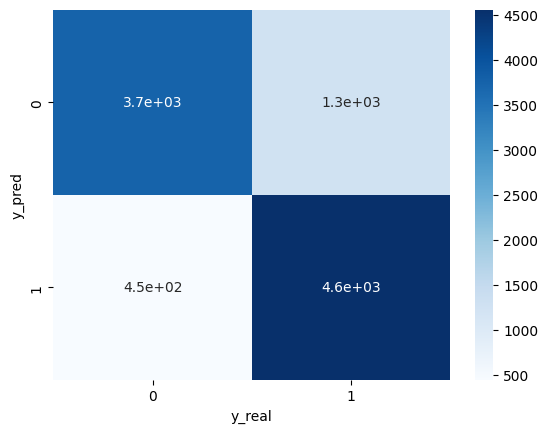

In [ ]:
resultados(modelo)

# Red Neuronal Grid

In [52]:
d_in = X_train.shape[1]
def create_model():
    modelo= keras.Sequential([
    keras.layers.Dense((d_in/2),input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

    modelo.compile(
      optimizer="adam",
      loss='binary_crossentropy',
      # metricas para ir calculando en cada iteracion o batch
      metrics=['accuracy'],
    )

    return modelo

In [51]:
!pip install scikeras

In [53]:
from scikeras.wrappers import KerasClassifier

In [ ]:
param_grid = {
    'epochs': [20],
    'batch_size' : [16,32,64],
    'callbacks' : [tf.keras.callbacks.EarlyStopping("accuracy",patience=5)]
}

print(param_grid)
modelo_cv = KerasClassifier(build_fn=create_model)
grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid,n_jobs=-1,cv=4)
grid_result = grid.fit(X_train, y_train)

{'epochs': [20], 'batch_size': [16, 32, 64], 'callbacks': [<keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>]}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
625/625 [==============================] - 8s 11ms/step - loss: 0.3902 - accuracy: 0.8265
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 0.3453 - accuracy: 0.8443
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3341 - accuracy: 0.8492
Epoch 4/20
625/625 [==============================] - 8s 12ms/step - loss: 0.3192 - accuracy: 0.8589
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.2971 - accuracy: 0.8718
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.2668 - accuracy: 0.8899
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2267 - accuracy: 0.9139
Epoch 8/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1790 - accuracy: 0.9419
Epoch 9/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1285 - accuracy: 0.9675
Epoch 10/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0836 - accura

Podemos ver que a partir de 10 epochs la red empieza a overfittear

In [ ]:
print_grid_results(grid_result)

Best: 0.844575 using {'batch_size': 64, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.841375 (0.001998) with: {'batch_size': 16, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.843975 (0.002063) with: {'batch_size': 32, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.844575 (0.002720) with: {'batch_size': 64, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}


In [ ]:
best_estimator = grid_result.best_estimator_

157/157 [==============================] - 2s 9ms/step
El accuracy es: 0.8492

El f1 es: 0.8513406940063091

El recall es: 0.8394245723172629

La precision es: 0.8636


              precision    recall  f1-score   support

           0       0.83      0.86      0.85      4856
           1       0.86      0.84      0.85      5144

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



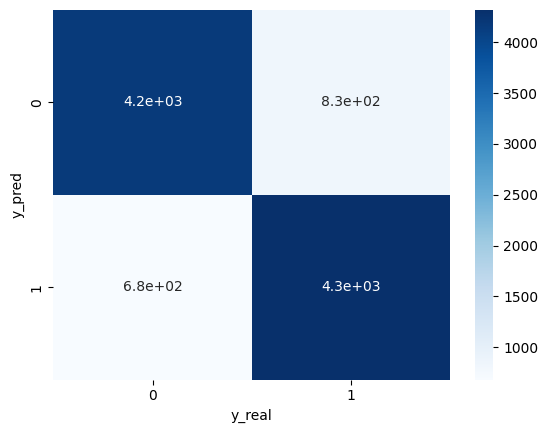

In [ ]:
resultados(best_estimator)

In [ ]:
joblib.dump(best_estimator, 'red_grid.joblib')

['red_grid.joblib']

# Red Neuronal 1

In [30]:
d_in = X_train.shape[1]
modelo1= keras.Sequential([
keras.layers.Dense(d_in,input_shape=(d_in,), activation='relu'),
keras.layers.Dropout(0.2),
keras.layers.Dense(1, activation='sigmoid')])

modelo1.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo1.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 21s 16ms/step - loss: 0.3908 - accuracy: 0.8256
Epoch 2/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3436 - accuracy: 0.8464
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3279 - accuracy: 0.8543
Epoch 4/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3095 - accuracy: 0.8656
Epoch 5/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2825 - accuracy: 0.8831
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2478 - accuracy: 0.9057
Epoch 7/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.2046 - accuracy: 0.9297
Epoch 8/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.1558 - accuracy: 0.9537
Epoch 9/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.1097 - accuracy: 0.9718
Epoch 10/10
1250/1250 [==============================] - 20s 16m

313/313 [==============================] - 2s 5ms/step
El accuracy es: 0.8417

El f1 es: 0.8478323560511392

El recall es: 0.8162132148806219

La precision es: 0.882


              precision    recall  f1-score   support

           0       0.80      0.87      0.84      4597
           1       0.88      0.82      0.85      5403

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



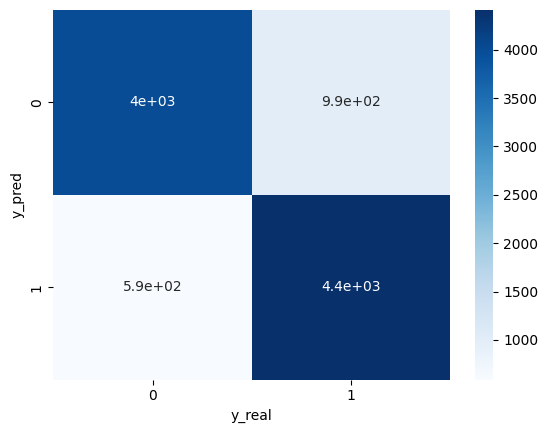

In [31]:
resultados(modelo1)

In [32]:
joblib.dump(modelo1, 'red_1.joblib')

['red_1.joblib']

# Red Neuronal 2

In [33]:
d_in = X_train.shape[1]
modelo2= keras.Sequential([
keras.layers.Dense(d_in,input_shape=(d_in,), activation='relu'),
keras.layers.Dropout(0.2),
keras.layers.Dense(1, activation='sigmoid')])

modelo2.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo2.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 21s 16ms/step - loss: 0.3913 - accuracy: 0.8260
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3433 - accuracy: 0.8466
Epoch 3/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.3276 - accuracy: 0.8551
Epoch 4/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3079 - accuracy: 0.8655
Epoch 5/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.2814 - accuracy: 0.8848
Epoch 6/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2467 - accuracy: 0.9069
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2028 - accuracy: 0.9311
Epoch 8/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.1551 - accuracy: 0.9531
Epoch 9/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.1091 - accuracy: 0.9714
Epoch 10/10
1250/1250 [==============================] - 20s 16m

313/313 [==============================] - 2s 5ms/step
El accuracy es: 0.8401

El f1 es: 0.8429427364698947

El recall es: 0.8282184906388728

La precision es: 0.8582


              precision    recall  f1-score   support

           0       0.82      0.85      0.84      4819
           1       0.86      0.83      0.84      5181

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



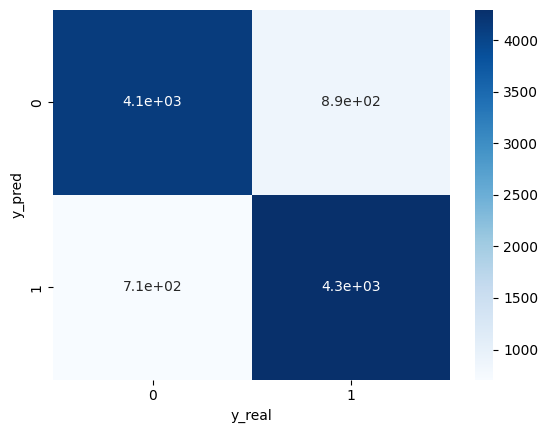

In [34]:
resultados(modelo2)

In [35]:
joblib.dump(modelo2, 'red_2.joblib')

['red_2.joblib']

# Red Neuronal 3

In [36]:
d_in = X_train.shape[1]
modelo3= keras.Sequential([
keras.layers.Dropout(0.2, input_shape=(d_in,)),
keras.layers.Dense(d_in, activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo3.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo3.fit(X_train,y_train,epochs=10)

Epoch 1/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4248 - accuracy: 0.8039
Epoch 2/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.3821 - accuracy: 0.8257
Epoch 3/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.3712 - accuracy: 0.8293
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3594 - accuracy: 0.8389
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3476 - accuracy: 0.8465
Epoch 6/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3289 - accuracy: 0.8586
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3105 - accuracy: 0.8714
Epoch 8/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2870 - accuracy: 0.8851
Epoch 9/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2632 - accuracy: 0.8986
Epoch 10/10
1250/1250 [==============================] - 20s 16m

313/313 [==============================] - 2s 7ms/step
El accuracy es: 0.841

El f1 es: 0.8474966430078651

El recall es: 0.8142277921120531

La precision es: 0.8836


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4574
           1       0.88      0.81      0.85      5426

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



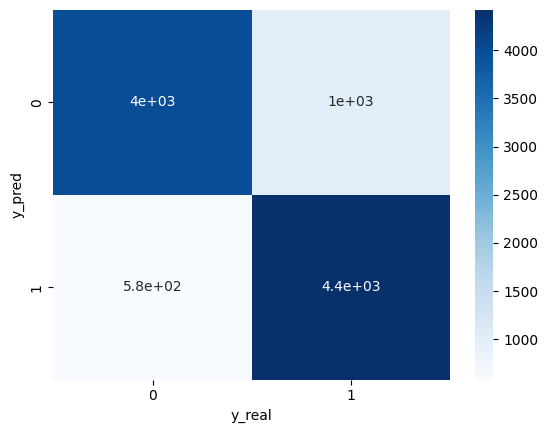

In [37]:
resultados(modelo3)

In [38]:
joblib.dump(modelo3, 'red_3.joblib')

['red_3.joblib']

#Red Neuronal 4

In [39]:
d_in = X_train.shape[1]
modelo4= keras.Sequential([
keras.layers.Dense(d_in, activation='relu'),
keras.layers.Dense((d_in/2), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo4.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo4.fit(X_train,y_train,epochs=5)

Epoch 1/5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.3838 - accuracy: 0.8235
Epoch 2/5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.3332 - accuracy: 0.8533
Epoch 3/5
1250/1250 [==============================] - 27s 22ms/step - loss: 0.2928 - accuracy: 0.8757
Epoch 4/5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.2096 - accuracy: 0.9215
Epoch 5/5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.1055 - accuracy: 0.9649


313/313 [==============================] - 2s 6ms/step
El accuracy es: 0.8339

El f1 es: 0.8411894062529879

El recall es: 0.8058252427184466

La precision es: 0.8798


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      4541
           1       0.88      0.81      0.84      5459

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.84      0.83      0.83     10000



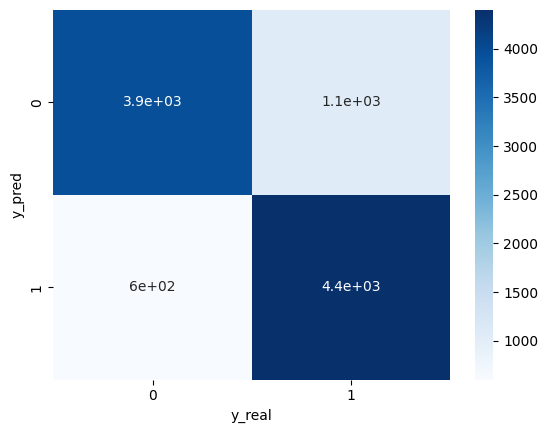

In [40]:
resultados(modelo4)

In [41]:
joblib.dump(modelo4, 'red_4.joblib')

['red_4.joblib']

#Red Neuronal 5

In [42]:
d_in = X_train.shape[1]
modelo5= keras.Sequential([
keras.layers.Dense((d_in/2), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo5.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo5.fit(X_train,y_train,epochs=5)

Epoch 1/5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3837 - accuracy: 0.8269
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.3432 - accuracy: 0.8473
Epoch 3/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.3235 - accuracy: 0.8585
Epoch 4/5
1250/1250 [==============================] - 11s 8ms/step - loss: 0.2914 - accuracy: 0.8758
Epoch 5/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2419 - accuracy: 0.9058


313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8385

El f1 es: 0.8472524354487847

El recall es: 0.8036963933249597

La precision es: 0.8958


              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4427
           1       0.90      0.80      0.85      5573

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



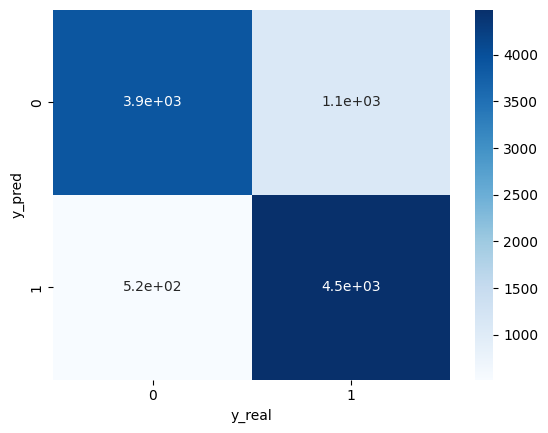

In [43]:
resultados(modelo5)

In [44]:
joblib.dump(modelo5, 'red_5.joblib')

['red_5.joblib']

Subimos el umbral

313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8416

El f1 es: 0.8470747248503573

El recall es: 0.8187756625606569

La precision es: 0.8774


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      4642
           1       0.88      0.82      0.85      5358

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



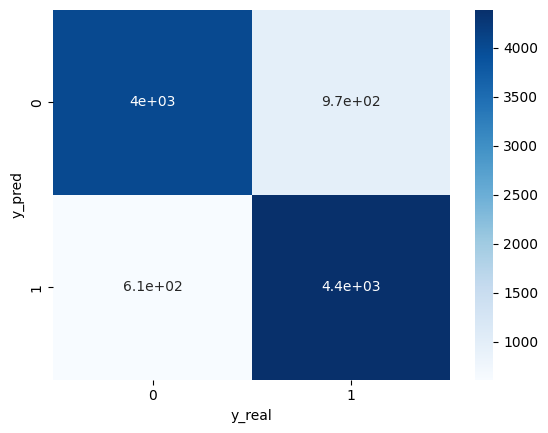

In [45]:
resultados(modelo5,0.45)

313/313 [==============================] - 1s 4ms/step
El accuracy es: 0.8444

El f1 es: 0.8464877663772692

El recall es: 0.8352803738317757

La precision es: 0.858


              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4864
           1       0.86      0.84      0.85      5136

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



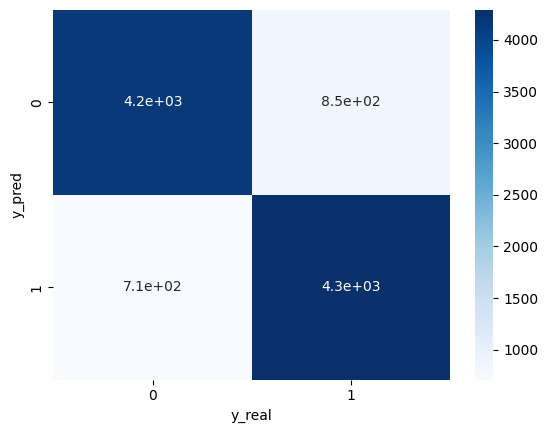

In [46]:
resultados(modelo5,0.5)

In [47]:
joblib.dump(modelo5, 'red_final.joblib')

['red_final.joblib']

# Submission 1

In [54]:
modelo = joblib.load('red_grid.joblib')

red=modelo.fit(X_train,y_train, epochs=10)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3902 - accuracy: 0.8253
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3449 - accuracy: 0.8451
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3331 - accuracy: 0.8512
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3163 - accuracy: 0.8593
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2925 - accuracy: 0.8740
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2609 - accuracy: 0.8938
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2182 - accuracy: 0.9200
Epoch 8/10
625/625 [==============================] - 7s 12ms/step - loss: 0.1686 - accuracy: 0.9476
Epoch 9/10
625/625 [==============================] - 6s 9ms/step - loss: 0.1180 - accuracy: 0.9725
Epoch 10/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0750 - accuracy:

In [56]:
X_TEST = vecTrain.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [57]:
X_TEST = vecTrain.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [58]:
y_pred = modelo.predict(X_TEST)
y_pred

135/135 [==============================] - 1s 4ms/step


array([0, 1, 0, ..., 0, 0, 0])

In [59]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [60]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,1
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,0
8597,68597,0


In [61]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [62]:
df_submission.to_csv("dsTP2RNSubGrid.csv",index=False)

# Submission 2

In [63]:
modelo = joblib.load('red_5.joblib')

red=modelo.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.1785 - accuracy: 0.9411
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.1135 - accuracy: 0.9717
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0601 - accuracy: 0.9900
Epoch 4/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0282 - accuracy: 0.9976
Epoch 5/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0129 - accuracy: 0.9994
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.0064 - accuracy: 0.9997
Epoch 7/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0031 - accuracy: 0.9999
Epoch 8/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 9/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.0011 - accuracy: 0.9999
Epoch 10/10
1250/1250 [==============================] - 11s 9ms/ste

In [64]:
X_TEST = vecTrain.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [65]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 4ms/step


array([[1.7464356e-04],
       [9.8357368e-01],
       [1.8110941e-06],
       ...,
       [5.2855723e-02],
       [5.8031763e-04],
       [2.2310271e-06]], dtype=float32)

In [66]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [67]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,1
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,0
8597,68597,0


In [68]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [69]:
df_submission.to_csv("dsTP2RNSubRed5.csv",index=False)

# Submission 3



In [70]:
modelo = joblib.load('red_3.joblib')

red=modelo.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2077 - accuracy: 0.9268
Epoch 2/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.1805 - accuracy: 0.9377
Epoch 3/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.1591 - accuracy: 0.9452
Epoch 4/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.1372 - accuracy: 0.9540
Epoch 5/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.1184 - accuracy: 0.9604
Epoch 6/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.1042 - accuracy: 0.9659
Epoch 7/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0923 - accuracy: 0.9696
Epoch 8/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0792 - accuracy: 0.9750
Epoch 9/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0720 - accuracy: 0.9760
Epoch 10/10
1250/1250 [==============================] - 20s 16m

In [71]:
X_TEST = vecTrain.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [72]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 4ms/step


array([[0.01352974],
       [0.99354935],
       [0.00702149],
       ...,
       [0.32922748],
       [0.63153934],
       [0.00234819]], dtype=float32)

In [73]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [74]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,1
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,0
8597,68597,1


In [75]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,positivo


In [76]:
df_submission.to_csv("dsTP2RNSubRed3.csv",index=False)

#Submission 4

In [22]:
modelo = joblib.load('red_final.joblib')

red=modelo.fit(X_train,y_train, epochs=5)

Epoch 1/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1777 - accuracy: 0.9417
Epoch 2/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1129 - accuracy: 0.9724
Epoch 3/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0603 - accuracy: 0.9902
Epoch 4/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0278 - accuracy: 0.9978
Epoch 5/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0131 - accuracy: 0.9993


In [23]:
X_TEST = vecTrain.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [24]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 3ms/step


array([[2.1157406e-02],
       [9.7188115e-01],
       [3.7010456e-04],
       ...,
       [5.3259468e-01],
       [7.9835142e-04],
       [1.2809304e-03]], dtype=float32)

In [25]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [26]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,1
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,1
8597,68597,0


In [27]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [28]:
df_submission.to_csv("dsTP2RNSub4.csv",index=False)